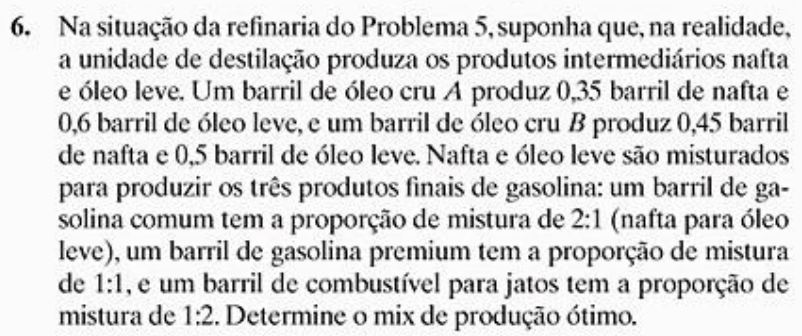

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Refinaria_Intermediarios')

In [3]:
# Identificadores
oleos_crus = ['A', 'B']
intermediarios = ['nafta', 'oleo_leve']
produtos_finais = ['comum', 'premium', 'jato']

# Dados do Óleo Cru
disponibilidade_cru = {'A': 2500, 'B': 3000} # barris/dia
custo_cru = {'A': 30, 'B': 40} # $/barril

# Estágio 1: Rendimento de intermediários por barril de óleo cru
rendimento_interm = {
    'A': {'nafta': 0.35, 'oleo_leve': 0.60},
    'B': {'nafta': 0.45, 'oleo_leve': 0.50}
}

# Estágio 2: Composição dos produtos finais a partir dos intermediários
composicao_final = {
    'comum':   {'nafta': 2/3, 'oleo_leve': 1/3},
    'premium': {'nafta': 1/2, 'oleo_leve': 1/2},
    'jato':    {'nafta': 1/3, 'oleo_leve': 2/3}
}

# Demanda fixa para os produtos finais (barris/dia)
demanda_final = {'comum': 500, 'premium': 700, 'jato': 400}

# Pré-cálculo da demanda total por produtos intermediários
demanda_intermediarios = {
    interm: sum(composicao_final[p][interm] * demanda_final[p] for p in produtos_finais)
    for interm in intermediarios
}
# Nafta necessária = (2/3)*500 + (1/2)*700 + (1/3)*400 = 816.67 barris
# Óleo Leve necessário = (1/3)*500 + (1/2)*700 + (2/3)*400 = 783.33 barris

In [4]:
# 1. Variáveis de Decisão
# Quantidade de cada óleo cru a ser processado (barris/dia)
oleo_usado = model.continuous_var_dict(oleos_crus, name='Cru', lb=0)


# 2. Função Objetivo
# Minimizar o custo total da compra de óleo cru
expressao_custo_cru = (custo_cru[o] * oleo_usado[o] for o in oleos_crus)
custo_total = model.sum(expressao_custo_cru)
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Disponibilidade de Óleo Cru
for o in oleos_crus:
    restr_disponibilidade_logica = oleo_usado[o] <= disponibilidade_cru[o]
    model.add_constraint(restr_disponibilidade_logica, ctname=f'disponibilidade_cru_{o}')

# Restrição 2: Atender à Demanda por Produtos Intermediários
# A quantidade produzida de cada intermediário deve ser no mínimo a quantidade necessária.
for interm in intermediarios:
    expressao_producao_interm = (rendimento_interm[o][interm] * oleo_usado[o] for o in oleos_crus)
    soma_producao_interm = model.sum(expressao_producao_interm)
    restr_demanda_interm_logica = soma_producao_interm >= demanda_intermediarios[interm]
    model.add_constraint(restr_demanda_interm_logica, ctname=f'demanda_{interm}')

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    custo_minimo = model.objective_value
    print(f"Custo Diário Mínimo de Operação: ${custo_minimo:,.2f}\n")

    print("--- Plano de Processamento de Óleo Cru ---")
    for o in oleos_crus:
        uso_val = oleo_usado[o].solution_value
        print(f"  - Óleo Cru {o}: {uso_val:,.2f} barris/dia")

    print("\n--- Mix de Produção (fixo pela demanda) ---")
    for p in produtos_finais:
        print(f"  - {p.capitalize()}: {demanda_final[p]} barris/dia")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 2 rows and 0 columns.
Reduced LP has 2 rows, 2 columns, and 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         70000.000000

------ SOLUÇÃO ÓTIMA ------

Custo Diário Mínimo de Operação: $70,000.00

--- Plano de Processamento de Óleo Cru ---
  - Óleo Cru A: 2,333.33 barris/dia
  - Óleo Cru B: 0.00 barris/dia

--- Mix de Produção (fixo pela demanda) ---
  - Comum: 500 barris/dia
  - Premium: 700 barris/dia
  - Jato: 400 barris/dia
